# VGGNet

[Paper here](https://arxiv.org/pdf/1409.1556)


In [1]:
from rich import print
from tqdm.notebook import tqdm
%load_ext rich


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import mlflow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.enable_system_metrics_logging()


In [4]:
# Hyperparameters

BATCH_SIZE = 8
N_EPOCHS = 30
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
N_CLASSES = 10

## Load the dataset


In [5]:
true_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


In [6]:
train_dataset = CIFAR10(
    root="./data/", download=True, train=True, transform=transforms.ToTensor()
)
test_dataset = CIFAR10(
    root="./data/", download=True, train=False, transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
mean_pixel_train = train_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_train = train_dataset.data.std(axis=(0, 1, 2)) / 255

mean_pixel_test = test_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_test = test_dataset.data.std(axis=(0, 1, 2)) / 255

(mean_pixel_train, std_pixel_train), (mean_pixel_test, std_pixel_test)



(
    (array([0.49139968, 0.48215841, 0.44653091]), array([0.24703223, 0.24348513, 0.26158784])),
    (array([0.49421428, 0.48513139, 0.45040909]), array([0.24665252, 0.24289226, 0.26159238]))
)

In [8]:
train_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_pixel_train, std_pixel_train),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_pixel_test, std_pixel_test),
    ]
)

In [9]:
def reverse_transform(x, train=True):
    mean_pixel, std_pixel = (
        mean_pixel_train if train else mean_pixel_test,
        std_pixel_train if train else std_pixel_test,
    )

    x = x * torch.tensor(std_pixel).view(3, 1, 1) + torch.tensor(mean_pixel).view(
        3, 1, 1
    )

    x = transforms.ToPILImage()(x)

    return x

In [10]:
full_train_dataset = CIFAR10(
    root="./data/", download=True, train=True, transform=train_transform
)

test_dataset = CIFAR10(
    root="./data/", download=True, train=False, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Taking a subset of the dataset to speed up training for demonstration purposes only
small_train_dataset = random_split(full_train_dataset, [0.3, 0.7])[0]
small_test_dataset = random_split(test_dataset, [0.3, 0.7])[0]

# Calculate the sizes for training and validation datasets (70-30 split)
train_size = int(0.7 * len(small_train_dataset))
val_size = len(small_train_dataset) - train_size

# Split the full training dataset into training and validation datasets
train_dataset, val_dataset = random_split(small_train_dataset, [train_size, val_size])


In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(small_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [13]:
len(train_loader), len(val_loader), len(test_loader)

(1313, 563, 375)

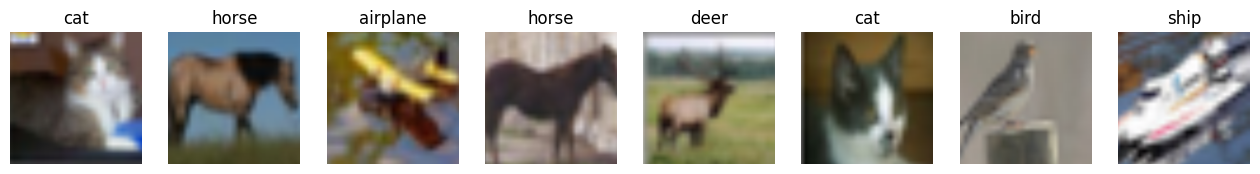

In [14]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
indices = torch.randperm(len(train_dataset))[:8]
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = reverse_transform(img, train=True)
    axs[i].imshow(img)
    axs[i].set_title(f"{true_labels[label]}")
    axs[i].axis("off")

plt.show()


## Build the architecture


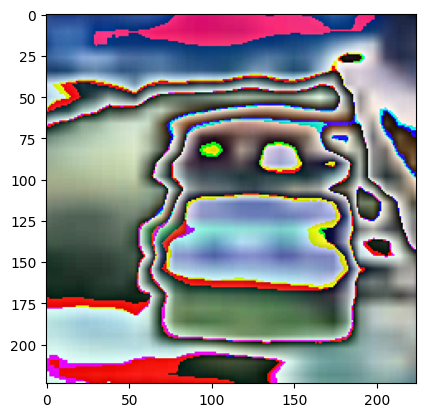

torch.Size([3, 224, 224])

8 ship

In [15]:
sample_image, sample_label = train_loader.dataset[1]
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()
print(sample_image.shape)
print(sample_label, true_labels[sample_label])

In [16]:
class Conv2dBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int = 64,
        kernel_size: int = 3,
        padding: int = 1,
        stride: int = 1,
    ):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=padding,
                stride=stride,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(x)


class VGGNet(nn.Module):
    def __init__(self, n_classes: int = 10, debug: bool = False):
        super().__init__()
        self.debug = debug
        self.n_classes = n_classes

        # B x 3 x 224 x 224 -> B x 64 x 112 x 112
        self.layer1 = nn.Sequential(
            # B x 3 x 224 x 224 -> B x 64 x 224 x 224
            Conv2dBlock(in_channels=3, out_channels=64, kernel_size=3),
            # B x 64 x 224 x 224 -> B x 64 x 224 x 224
            Conv2dBlock(in_channels=64, out_channels=64, kernel_size=3),
            # B x 64 x 224 x 224 -> B x 64 x 112 x 112
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # B x 64 x 112 x 112 -> B x 128 x 56 x 56
        self.layer2 = nn.Sequential(
            # B x 64 x 112 x 112 -> B x 128 x 112 x 112
            Conv2dBlock(in_channels=64, out_channels=128, kernel_size=3),
            # B x 128 x 112 x 112 -> B x 128 x 112 x 112
            Conv2dBlock(in_channels=128, out_channels=128, kernel_size=3),
            # B x 128 x 112 x 112 -> B x 128 x 56 x 56
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # B x 128 x 56 x 56 -> B x 256 x 28 x 28
        self.layer3 = nn.Sequential(
            # B x 128 x 56 x 56 -> B x 256 x 56 x 56
            Conv2dBlock(in_channels=128, out_channels=256, kernel_size=3),
            # B x 256 x 56 x 56 -> B x 256 x 56 x 56
            Conv2dBlock(in_channels=256, out_channels=256, kernel_size=3),
            # B x 256 x 56 x 56 -> B x 256 x 56 x 56
            Conv2dBlock(in_channels=256, out_channels=256, kernel_size=3),
            # B x 256 x 56 x 56 -> B x 256 x 28 x 28
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # B x 256 x 28 x 28 -> B x 512 x 14 x 14
        self.layer4 = nn.Sequential(
            # B x 256 x 28 x 28 -> B x 512 x 28 x 28
            Conv2dBlock(in_channels=256, out_channels=512, kernel_size=3),
            # B x 512 x 28 x 28 -> B x 512 x 28 x 28
            Conv2dBlock(in_channels=512, out_channels=512, kernel_size=3),
            # B x 512 x 28 x 28 -> B x 512 x 28 x 28
            Conv2dBlock(in_channels=512, out_channels=512, kernel_size=3),
            # B x 512 x 28 x 28 -> B x 512 x 14 x 14
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # B x 512 x 14 x 14 -> B x 512 x 7 x 7
        self.layer5 = nn.Sequential(
            # B x 512 x 14 x 14 -> B x 512 x 14 x 14
            Conv2dBlock(in_channels=512, out_channels=512, kernel_size=3),
            # B x 512 x 14 x 14 -> B x 512 x 14 x 14
            Conv2dBlock(in_channels=512, out_channels=512, kernel_size=3),
            # B x 512 x 14 x 14 -> B x 512 x 14 x 14
            Conv2dBlock(in_channels=512, out_channels=512, kernel_size=3),
            # B x 512 x 14 x 14 -> B x 512 x 7 x 7
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # B x 512 x 7 x 7 -> B x 4096
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=(512 * 7 * 7), out_features=4096),
            nn.ReLU(),
        )

        # B x 4096 -> B x 4096
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
        )

        # B x 4096 -> # B x N_CLASSES
        self.fc3 = nn.Linear(4096, self.n_classes)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._debug_print(x, "Input")
        x = self.layer1(x)
        self._debug_print(x, "Layer1")
        x = self.layer2(x)
        self._debug_print(x, "Layer2")
        x = self.layer3(x)
        self._debug_print(x, "Layer3")
        x = self.layer4(x)
        self._debug_print(x, "Layer4")
        x = self.layer5(x)
        self._debug_print(x, "Layer5")
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        self._debug_print(x, "FC1")
        x = self.fc2(x)
        self._debug_print(x, "FC2")
        x = self.fc3(x)
        self._debug_print(x, "Output")

        return x

In [17]:
model = VGGNet(debug=True).to(device)
x = model(sample_image.unsqueeze(0).to(device))


Input: torch.Size([1, 3, 224, 224])

Layer1: torch.Size([1, 64, 112, 112])

Layer2: torch.Size([1, 128, 56, 56])

Layer3: torch.Size([1, 256, 28, 28])

Layer4: torch.Size([1, 512, 14, 14])

Layer5: torch.Size([1, 512, 7, 7])

FC1: torch.Size([1, 4096])

FC2: torch.Size([1, 4096])

Output: torch.Size([1, 10])

In [18]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 134309962

## Train the model

In [19]:
model = VGGNet(n_classes=N_CLASSES, debug=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1
)

In [20]:
mlflow.set_experiment(experiment_name="vggnet")

<Experiment: artifact_location='mlflow-artifacts:/203950544768537115', creation_time=1721448495671, experiment_id='203950544768537115', last_update_time=1721448495671, lifecycle_stage='active', name='vggnet', tags={}>

In [21]:
# with mlflow.start_run() as run:
# run_id = run.info.run_id
# Log hyperparameters
# mlflow.log_params(
#     {
#         "N_EPOCHS": N_EPOCHS,
#         "LEARNING_RATE": LEARNING_RATE,
#         "BATCH_SIZE": BATCH_SIZE,
#         "Optimizer": optimizer.__class__.__name__,
#         "Loss Function": criterion.__class__.__name__,
#     }
# )

for epoch in tqdm(range(2), desc="Epochs"):
    # ---------- Training ----------
    train_loss = 0

    for batch, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        model.train()

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}")
    # mlflow.log_metric("train_loss", train_loss, step=epoch)

    # ---------- Validation ----------

    val_loss = 0
    correct = 0
    total = 0

    label_in_top_5 = 0

    # Custom evaluation metric: Label in top 5 predictions

    model.eval()
    with torch.inference_mode():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss += criterion(outputs, labels)

            top5_preds = outputs.topk(k=5, dim=-1).indices

            total += labels.size(0)
            correct += (labels == outputs.argmax(dim=-1)).sum().item()
            label_in_top_5 += (
                (labels.view(-1, 1) == top5_preds).any(dim=-1).sum().item()
            )

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_top_5_error = label_in_top_5 / total
        scheduler.step(val_loss)

        print(
            f"Epoch: {epoch} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%} | Val Top 5 Error: {val_top_5_error:.2%}"
        )

#     mlflow.log_metric("val_loss", val_loss, step=epoch)
#     mlflow.log_metric("val_acc", val_acc, step=epoch)

# mlflow.pytorch.log_model(model, "model")

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/1313 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:21                                                                                   │
│                                                                                                  │
│   18 │   for batch, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):          │
│   19 │   │   model.train()                                                                       │
│   20 │   │                                                                                       │
│ ❱ 21 │   │   inputs, labels = inputs.to(device), labels.to(device)                               │
│   22 │   │                                                                                       │
│   23 │   │   outputs = model(inputs)                                                             │
│   24 │   │   loss = criterion(outputs, labels)                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

## Test the model

In [23]:
model.eval()

test_loss = 0
correct = 0
total = 0
# with mlflow.start_run(run_id=run_id):
with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        test_loss += criterion(outputs, labels)

        total += labels.size(0)
        correct += (labels == outputs.argmax(dim=-1)).sum().item()

    test_loss /= len(test_loader)
    test_acc = correct / total

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}")

# mlflow.log_metric("test_loss", test_loss)
# mlflow.log_metric("test_acc", test_acc)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
│                                                                                                  │
│   12 │   │   test_loss += criterion(outputs, labels)                                             │
│   13 │   │                                                                                       │
│   14 │   │   total += labels.size(0)                                                             │
│ ❱ 15 │   │   correct += (labels == outputs.argmax(dim=-1)).sum().item()                          │
│   16 │                                                                                           │
│   17 │   test_loss /= len(test_loader)                                                           │
│   18 │   test_acc = correct / total                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

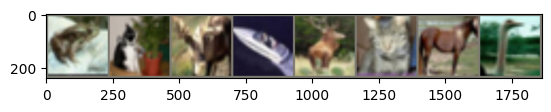

Index     Predicted Actual

0         automobilefrog

1         ship      cat

2         ship      deer

3         ship      ship

4         dog       deer

5         ship      cat

6         dog       horse

7         automobilebird

In [24]:
sample_test_images, sample_test_labels = next(iter(test_loader))

plt.imshow(
    reverse_transform(make_grid(sample_test_images, nrow=16, padding=8, scale_each=3))
)

plt.show()

prediction = model(sample_test_images.to(device))

predicted_labels = prediction.argmax(dim=-1).cpu().numpy()
actual_labels = sample_test_labels.cpu().numpy()

print(f"{'Index':<10}{'Predicted':<10}{'Actual':<10}")
for i, (pred, actual) in enumerate(zip(predicted_labels, actual_labels)):
    print(f"{i:<10}{true_labels[pred]:<10}{true_labels[actual]:<10}", end="\n")